In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import mean_squared_error
InteractiveShell.ast_node_interactivity = "all" # 한 실행칸에 프린트 여러개 해도 다 출력시키도록 하는 코드.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def Thomas_algo1(a, b, c, d):
    n = len(d) 
    _c = np.zeros(n)
    _d = np.zeros(n)
    x = np.zeros(n)
    _c[0] = c[0]/a[0]
    _d[0] = d[0]/a[0]
    for i in range(1, n):
        _c[i] = ( c[i] / (a[i]-b[i]*_c[i-1]) )
        _d[i] = ( (d[i] - b[i] * _d[i-1]) / (a[i] - b[i] * _c[i-1]) )
        
    x[n-1] = _d[n-1]
    for i in range(n-2, -1, -1):
        x[i] = _d[i] - _c[i] * x[i+1]
    
    return x

In [4]:
# 유안타 MY ELS 제4623호 (KOSPI200, KOSPI)
# 추산가격 : 8399원

K = [0.92, 0.90, 0.85, 0.85, 0.80, 0.80] # strike prices
B = 0.55 # Barrier
r = 0.0063 # 10월 8일의 CD91금리
cr = np.arange(1, 7) * 0.0305
dates = [0, 0.5, 1, 1.5, 2, 2.5] # 반년에 1번씩 early redemtion date
S0_2 = 60000
S0_1 = 313.92
vol_2 = 0.3050883903
vol_1 = 0.1798025777
D_2 = 0.03
D_1 = 0.02
dx_1 = S0_1 * 0.01
dx_2 = S0_2 * 0.01
I = 400
Smin_1 = 0
Smin_2 = 0
pp = 50 # number of time points
N = 3 * pp
T = 3 # maturity
corr = 0.5831793444

In [5]:
def ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'ADI'): # 참고용.
    dt = T/N
    Smax_1 = dx_1 * I
    Smax_2 = dx_2 * I
    S_1 = np.linspace(Smin_1, Smax_1, I+1)
    S_2 = np.linspace(Smin_2, Smax_2, I+1)
    x_1 = S_1/S0_1
    x_2 = S_2/S0_2
    S0_point = np.where(S_1 == S0_1)[0][0]
    Btag = int(round(S0_point* B)) # Btag : barrier 가격의 index
    # Coefficients of x, y for FDM and boundary condition adjustment
    tmp = np.arange(1, I)
    if method == 'ADI':
        a1 = 1 + dt/2*(r + (r-D_1) * tmp + (vol_1**2) * (tmp**2))
        b1 = -dt/4*(vol_1**2)*(tmp**2)
        c1 = -dt/2*((r-D_1)*tmp + (vol_1**2)/2 * (tmp**2))
        a2 = 1 + dt/2*(r + (r-D_2) * tmp + (vol_2**2) * (tmp**2))
        b2 = -dt/4*(vol_2**2)*(tmp**2)
        c2 = -dt/2*((r-D_2)*tmp + (vol_2**2)/2 * (tmp**2))
    elif method == 'OS':
        a1 = 1 + dt * (r/2 + (r-D_1)*tmp + (tmp**2)*(vol_1**2))
        a2 = 1 + dt * (r/2 + (r-D_2)*tmp + (tmp**2)*(vol_2**2))
        b1 = -dt/2 * (tmp**2) * (vol_1**2)
        b2 = -dt/2 * (tmp**2) * (vol_2**2)
        c1 = -dt * ( (r-D_1)*tmp + (vol_1**2)/2*(tmp**2))
        c2 = -dt * ( (r-D_2)*tmp + (vol_2**2)/2*(tmp**2))
    else:
        print('InputError: use method "ADI" or "OS"')
        return -1
    a1_prime = a1.copy()
    b1_prime = b1.copy()
    c1_prime = c1.copy()
    a2_prime = a2.copy()
    b2_prime = b2.copy()
    c2_prime = c2.copy()
    a1_prime[0] = a1[0] + 2*b1[0]
    c1_prime[0] = c1[0] - b1[0]
    a2_prime[0] = a2[0] + 2*b2[0]
    c2_prime[0] = c2[0] - b2[0]
    #a_prime[I-2] = a[I-2] + 2*c[I-2]
    #b_prime[I-2] = b[I-2] - c[I-2]
    a1_prime[I-2] = a1[I-2] + 2*c1[I-2]
    b1_prime[I-2] = b1[I-2] - c1[I-2]
    a2_prime[I-2] = a2[I-2] + 2*c2[I-2]
    b2_prime[I-2] = b2[I-2] - c2[I-2]

    # Initial conditions, u(0, j) and w(0, j) are determined
    u = np.zeros((N+1, I+1, I+1))
    w = np.zeros((N+1, I+1, I+1))
    
    
    # initial setting
    for i in range(I+1):
        for j in range(I+1):
            if(x_1[i] > B) & (x_2[j] > B):
                u[0,i,j] = (1 + cr[5])
            else:
                u[0,i,j] = min(x_1[i], x_2[j])
            
            if(x_1[i] >= K[5]) & (x_2[j] >= K[5]):
                w[0, i, j] = (1+cr[5])
            else:
                w[0, i, j] = min(x_1[i], x_2[j])

    
    u[0, 0, :] = 2 * u[0, 1, :] - u[0, 2, :]
    u[0, :, 0] = 2 * u[0, :, 1] - u[0, :, 2]
    u[0, :, I] = 2 * u[0, :, I-1] - u[0, :, I-2]
    u[0, I, :] = 2 * u[0, I-1, :] - u[0, I-2, :]
    w[0, 0, :] = 2 * w[0, 1, :] - w[0, 2, :]
    w[0, :, 0] = 2 * w[0, :, 1] - w[0, :, 2]
    w[0, :, I] = 2 * w[0, :, I-1] - w[0, :, I-2]
    w[0, I, :] = 2 * w[0, I-1, :] - w[0, I-2, :]
    
    
    
    
    u2 = np.zeros((I+1, I+1))
    w2 = np.zeros((I+1, I+1))
    for n in range(0, N):
        print(n+1)
        # First Stage
        for j in range(1, I): # Y
            if method == 'ADI':
                d = u[n,1:-1,j] + dt * (r-D_2) * j/2 * (u[n,1:-1,j+1] - u[n,1:-1,j])
                + dt*(vol_2**2)/4*(j*j) * (u[n,1:-1,j+1]-2*u[n,1:-1,j]+u[n,1:-1,j-1])
                + dt*corr*vol_1*vol_2* tmp *j /8*(u[n,2:,j+1] + u[n,:-2, j-1] 
                                                  - u[n,:-2,j+1] - u[n, 2:,j-1])
                d2 = w[n,1:-1,j] + dt * (r-D_2) * j/2 * (w[n,1:-1,j+1] - w[n,1:-1,j])
                + dt*(vol_2**2)/4*(j*j) * (w[n,1:-1,j+1]-2*w[n,1:-1,j]+w[n,1:-1,j-1])
                + dt*corr*vol_1*vol_2* tmp *j /8*(w[n,2:,j+1] + w[n,:-2, j-1] 
                                                  - w[n,:-2,j+1] - w[n, 2:,j-1]) 
            elif method == 'OS':
                d = u[n, 1:-1, j] + dt*corr*vol_1*vol_2* tmp * j /8 *(u[n,2:,j+1] + u[n,:-2, j-1] - u[n,:-2,j+1] - u[n, 2:,j-1])
                d2 = w[n, 1:-1, j] + dt*corr*vol_1*vol_2* tmp * j /8 *(w[n,2:,j+1] + w[n,:-2, j-1] - w[n,:-2,j+1] - w[n, 2:,j-1]) 
            u2[1:I,j] = Thomas_algo1(a1_prime, b1_prime, c1_prime, d)
            w2[1:I,j] = Thomas_algo1(a1_prime, b1_prime, c1_prime, d2)
        
        
        # u_star, w_star boundary condition
        u2[:, 0] = 2*u2[:,1]-u2[:,2]
        u2[:, -1] = 2*u2[:,-2]-u2[:,-3]
        u2[0, :] = 2*u2[1,:] - u2[2,:]
        u2[-1, :] = 2*u2[-2,:] - u2[-3,:]
        w2[:, 0] = 2*w2[:,1]-w2[:,2]
        w2[:, -1] = 2*w2[:,-2]-w2[:,-3]
        w2[0, :] = 2*w2[1,:] - w2[2,:]
        w2[-1, :] = 2*w2[-2,:] - w2[-3,:]
        
        # u star barriar hit
        u2[:, 1:Btag+1] = w2[:, 1:Btag+1]
        u2[1:Btag+1, :] = w2[1:Btag+1, :]
        
        
            
        # Second stage    
        for i in range(1, I): # X    
            if method == 'ADI':
                d = u2[i,1:-1] + dt * (r-D_1) * i/2 * (u2[i,2:] - u2[i,1:-1])
                + dt*(vol_1**2)/4*(i*i) * (u2[i,2:]-2*u2[i,1:-1]+u2[i,:-2])
                + dt*corr*vol_1*vol_2*tmp*i/8*(u2[i+1,2:] + u2[i-1, :-2] 
                                               - u2[i+1,:-2] - u2[i-1,2:])
                d2 = w2[i,1:-1] + dt * (r-D_1) * i/2 * (w2[i,2:] - w2[i,1:-1])
                + dt*(vol_1**2)/4*(i*i) * (w2[i,2:]-2*w2[i,1:-1]+w2[i,:-2])
                + dt*corr*vol_1*vol_2*tmp*i/8*(w2[i+1,2:] + w2[i-1, :-2] 
                                               - w2[i+1,:-2] - w2[i-1,2:])
            elif method == 'OS':
                d = u2[i, 1:-1] + dt*corr*vol_1*vol_2*tmp*i/8 *(u2[i+1,2:] + u2[i-1, :-2] - u2[i+1,:-2] - u2[i-1,2:])
                d2 = w2[i, 1:-1] + dt*corr*vol_1*vol_2*tmp*i/8 *(w2[i+1,2:] + w2[i-1, :-2] - w2[i+1,:-2] - w2[i-1,2:])
            u[n+1,i,1:-1] = Thomas_algo1(a2_prime, b2_prime, c2_prime, d)
            w[n+1,i,1:-1] = Thomas_algo1(a2_prime, b2_prime, c2_prime, d2)
            
        # fix over strike price at the early redemtion date.
        if n*dt in dates:
            dummy = int(round(S0_point * K[len(K) -1 - round((n+1)*dt*2)])) # dummy : strike price index
#             print(int(round(S0_point * K[len(K) -1 - round((n+1)*dt*2)])))
#             u[n+1, :, dummy : I+1] = 1 + cr[round(len(cr) - round((n+1)*dt, 1)*2)-1]
#             w[n+1, :, dummy : I+1] = 1 + cr[round(len(cr) - round((n+1)*dt, 1)*2)-1]
#             u[n+1, dummy : I+1, :] = 1 + cr[round(len(cr) - round((n+1)*dt, 1)*2)-1]
#             w[n+1, dummy : I+1, :] = 1 + cr[round(len(cr) - round((n+1)*dt, 1)*2)-1]
            u[n+1,dummy:,dummy:] = 1 + cr[round(len(cr) - round((n+1)*dt, 1)*2)-1]
            w[n+1,dummy:,dummy:] = 1 + cr[round(len(cr) - round((n+1)*dt, 1)*2)-1]
        
        
        # barrier
        u[n+1, :, 1:Btag+1] = w[n+1, :, 1:Btag+1]
        u[n+1, 1:Btag+1, :] = w[n+1, 1:Btag+1, :]
        
        # boundary condition
        u[n+1, 0, :] = 2 * u[n+1, 1, :] - u[n+1, 2, :]
        u[n+1, :, 0] = 2 * u[n+1, :, 1] - u[n+1, :, 2]
        u[n+1, :, I] = 2 * u[n+1, :, I-1] - u[n+1, :, I-2]
        u[n+1, I, :] = 2 * u[n+1, I-1, :] - u[n+1, I-2, :]
        w[n+1, 0, :] = 2 * w[n+1, 1, :] - w[n+1, 2, :]
        w[n+1, :, 0] = 2 * w[n+1, :, 1] - w[n+1, :, 2]
        w[n+1, :, I] = 2 * w[n+1, :, I-1] - w[n+1, :, I-2]
        w[n+1, I, :] = 2 * w[n+1, I-1, :] - w[n+1, I-2, :]
        
    return u, w

In [6]:
u_adi, w_adi = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r, D_1, D_2, 
                            S0_1, S0_2, cr, K, B, dates, method = 'ADI')
u_os, w_os = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r, D_1, D_2, 
                            S0_1, S0_2, cr, K, B, dates, method = 'OS')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [7]:
u_adi[-1,I//4,I//4]
u_os[-1,I//4,I//4]

0.9912800165483859

0.9325635263687104

In [8]:
def ELS_TwoStar_Simulation(s0_1, s0_2, mu, vol_1, vol_2, corr, 
                           r, D_1, D_2, cr, K, B, N, dates, T):
    s1 = np.zeros(N+1)
    s2 = np.zeros(N+1)
    x1 = np.zeros(N+1)
    x2 = np.zeros(N+1)
    dt = T/N
    x1[0] = 1
    x2[0] = 1
    s1[0] = s0_1
    s2[0] = s0_2
    cnt = 0
    total_iter = 50000
    sprice = 0
    for i in range(total_iter):
        if(i % (total_iter//10) == 0):   
            print('iter: {}, {}% complete'.format(i, i/total_iter * 100))
        KI = 0 # Knock-In
        
        # 하나의 시나리오 만들어내기.
        for j in range(N):
            e = np.random.randn(2)
            s1[j+1] = s1[j] * np.exp((r-D_1-0.5*vol_1**2)*dt + np.sqrt(dt)*(vol_1*e[0]))
            s2[j+1] = s2[j] * np.exp((r-D_2-0.5*vol_2**2)*dt 
                                   + np.sqrt(dt)*(corr*vol_2*e[0]+np.sqrt(1-corr**2)*vol_2*e[1]))

            x1[j+1] = s1[j+1]/s0_1
            x2[j+1] = s2[j+1]/s0_2
        
        # 시나리오의 상황을 체크한다.
        # 1. Barrier를 Knock-In 한적 있는가?
        if min(x1) <= B or min(x2) <= B:
            KI = 1
            cnt = cnt+1
        
        # 2. 첫번째 조기상환 기간에 조기상환 되었는가?
        if x1[N//6] >= K[0] and x2[N//6] >= K[0]:
            price = (1+cr[0]) * np.exp(-r*dates[0])
        # 3. 두번째 조기상환 기간에 조기상환 되었는가?
        elif x1[N//6*2] >= K[1] and x2[N//6*2] >= K[1]:
            price = (1+cr[1]) * np.exp(-r*dates[1])
        # 4. 세번째 조기상환 기간에 조기상환 되었는가?
        elif x1[N//6*3] >= K[2] and x2[N//6*3] >= K[2]:
            price = (1+cr[2]) * np.exp(-r*dates[2])
        # 5. 네번째 조기상환 기간에 조기상환 되었는가?
        elif x1[N//6*4] >= K[3] and x2[N//6*4] >= K[3]:
            price = (1+cr[3]) * np.exp(-r*dates[3])
        # 6. 다섯번째 조기상환 기간에 조기상환 되었는가?
        elif x1[N//6*5] >= K[4] and x2[N//6*5] >= K[4]:
            price = (1+cr[4]) * np.exp(-r*dates[4])
        # 7. 만기 상환관련 이슈. 만기에 가격이 행사가격보다 높은가?
        elif x1[N] >= K[5] and x2[N] >= K[5]:
            price = (1+cr[5]) * np.exp(-r*dates[5])
        # 8. 두 번째 만기 관련 이슈. 배리어를 친적이 있는가? 그렇다면, 행사가격보다 낮기도 하기 때문에.. 낮은가격!
        elif KI == 1:
            price = min(x1[N], x2[N]) * np.exp(-r*dates[5])
        else: # 배리어를 친 적은 없고, 만기 가격이 (배리어 ~ 행사가격) 사이인 경우.
            price = (1+cr[5]) * np.exp(-r*dates[5])
        sprice = sprice + price
    sprice = sprice / total_iter
    prob = cnt / total_iter
    print('Simulation price and probability of KI: %.4f, %.4f \n\n' %(sprice, prob))
    

In [9]:
ELS_TwoStar_Simulation(S0_1, S0_2, r, vol_1, vol_2, corr, 
                           r, D_1, D_2, cr, K, B, N, dates, T)

iter: 0, 0.0% complete
iter: 5000, 10.0% complete
iter: 10000, 20.0% complete
iter: 15000, 30.0% complete
iter: 20000, 40.0% complete
iter: 25000, 50.0% complete
iter: 30000, 60.0% complete
iter: 35000, 70.0% complete
iter: 40000, 80.0% complete
iter: 45000, 90.0% complete
Simulation price and probability of KI: 0.9273, 0.3851 




Text(0.5, 0.92, 'Price distribution')

Text(0.5, 0, 'KOSPI2')

Text(0.5, 0, 'POSCO')

Text(0.5, 0, 'ELS price')

(-1.01, 2)

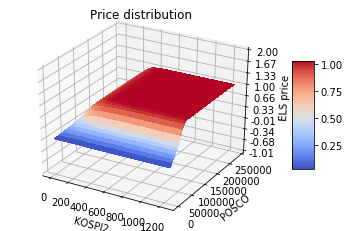

In [22]:
fig = plt.figure()

X = np.arange(I+1) * 0.01 * S0_1
Y = np.arange(I+1) * 0.01 * S0_2
X, Y = np.meshgrid(X, Y)
Z = u_os[N,:,:]

ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('Price distribution')
ax.set_xlabel('KOSPI2')
ax.set_ylabel('POSCO')
ax.set_zlabel('ELS price')
ax.set_zlim(-1.01, 2)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [11]:
u_os = 10000 * u_os
delta_x = (u_os[N, 1:,I//4] - u_os[N, :-1,I//4])/dx_1
gamma_x = (delta_x[1:]-delta_x[:-1])/dx_1
delta_y = (u_os[N,I//4, 1:] - u_os[N,I//4, :-1])/dx_2
gamma_y = (delta_y[1:]-delta_y[:-1])/dx_2

In [12]:
# delta와 gamma산출. (Sx0, Sy0 각각 기준으로 하여 구하였음.)
delta_x[len(delta_x)//4]
gamma_x[len(gamma_x)//4]
delta_y[len(delta_y)//4]
gamma_y[len(gamma_y)//4]

5.560425603583967

-0.19365742787760262

0.06916689497892851

-5.569649986627058e-06

In [13]:
# Vega_x
u_1, _ = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'OS') # 참고용.
u_1 = 10000 * u_1[N, I//4, I//4]
u_2, _ = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1+0.001, vol_2, r, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'OS') # 참고용.
u_2 = 10000 * u_2[N, I//4, I//4]
vega_x = (u_2-u_1)/0.001

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [14]:
# Vega_y
u_1_, _ = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'OS') # 참고용.
u_1_ = 10000 * u_1_[N, I//4, I//4]
u_2_, _ = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2+0.001, r, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'OS') # 참고용.
u_2_ = 10000 * u_2_[N, I//4, I//4]
vega_y = (u_2_-u_1_)/0.001

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [15]:
# Cross-gamma
delta_x = (u_os[N, 1:I+1,:] - u_os[N, 0:I,:]) / dx_1
y_delta_x = (delta_x[:,1:I+1] - delta_x[:,0:I]) / dx_2
cross_gamma = y_delta_x[I//4,I//4] # Sx0, Sy0 기준 cross-gamma

In [16]:
vega_x
vega_y
cross_gamma

-2649.064758337772

-5316.1270799646445

0.00020572966469118253

In [18]:
# rho
u_1, _ = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'OS') # 참고용.
u_1 = 10000 * u_1[N, I//4, I//4]
u_2, _ = ELS_TwoStar_ADIOSFDM(T, I, N, Smin_1, Smin_2, dx_1, dx_2, vol_1, vol_2, r+0.001, D_1, D_2, S0_1, S0_2, cr, K, B, dates, method = 'OS') # 참고용.
u_2 = 10000 * u_2[N, I//4, I//4]
rho = (u_2-u_1)/0.001
rho

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


-1153.1337067717686

In [20]:
# theta
theta = (u_os[N,I//4,I//4] - u_os[N-1,I//4,I//4])/(T/N)
theta

-1293.148271935297